In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Simulation parameters
resolution = 10  # pixels/um
pml_thickness = 2
cell_x = 16
cell_y = 16
cell_z = 16

sphere_radius = 1.0
sphere_eps = 2.56
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 10  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)



In [3]:
# Materials
substrate_material = mp.Medium(epsilon=substrate_eps)
def bump_material(p):
    bump_height = 0.3 * np.exp(-((p.x)**2 + (p.y)**2) / 0.2**2)
    z_surface = -0.5 + bump_height
    return substrate_material if p.z < z_surface else mp.air

# Source: downward plane wave at angles
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),
        direction=mp.Z,  # still Z, but mode defines propagation
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True
    )
]


# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources, # you can still add discrete objects
    default_material=bump_material
)


# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00377011 s
Working in 3D dimensions.
Computational cell is 16 x 16 x 16 with resolution 10
subpixel-averaging is 29.9081% done, 9.37547 s remaining
subpixel-averaging is 71.9813% done, 1.55778 s remaining
subpixel-averaging is 71.9001% done, 1.56423 s remaining
subpixel-averaging is 28.1279% done, 10.2279 s remaining
subpixel-averaging is 51.9238% done, 3.70409 s remaining
subpixel-averaging is 75.6011% done, 1.29266 s remaining
subpixel-averaging is 97.2015% done, 0.115355 s remaining
subpixel-averaging is 75.4309% done, 1.30558 s remaining
subpixel-averaging is 24.6267% done, 12.2582 s remaining
subpixel-averaging is 51.8645% done, 3.7156 s remaining
subpixel-averaging is 78.6869% done, 1.08467 s remaining
time for set_epsilon = 118.147 s
-----------
MPB solved for frequency_1(0.173648,0,-0.984808) = 0.984905 after 131 iters
MPB solved for frequency_1(0.173648,0,-0.999904) = 1 after 1 iters
MPB solved for frequen

Flux through top: 35.357526
Flux through bottom: -264.264456
Flux through left: 1.081842
Flux through right: -8.055796
Flux through front: 4.821140
Flux through back: -5.473978


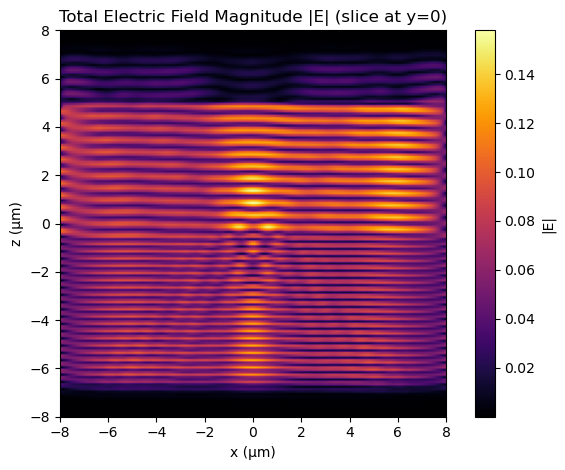

In [4]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Get all field components for total |E| calculation
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ez)

abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# Plot total field magnitude
plt.figure(dpi=100)
plt.imshow(abs_E.T, cmap='inferno', origin='lower', extent=[-cell_x/2, cell_x/2, -cell_z/2, cell_z/2])
plt.colorbar(label='|E|')
plt.xlabel('x (µm)')
plt.ylabel('z (µm)')
plt.title('Total Electric Field Magnitude |E| (slice at y=0)')
plt.tight_layout()
plt.show()

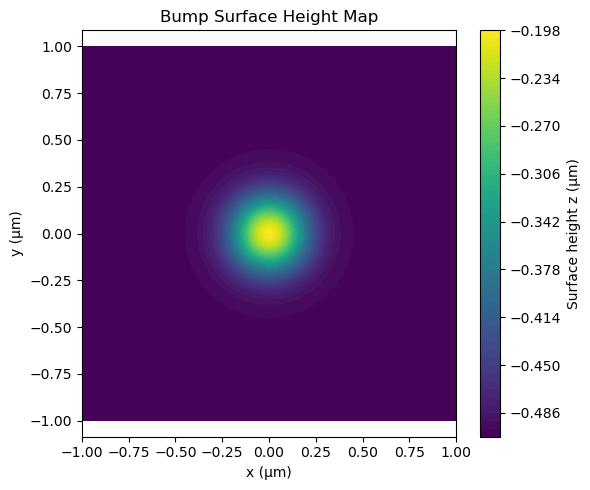

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid for x and y
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)

# Define bump surface: z = -0.5 + bump_height
bump_height = 0.3 * np.exp(-(X**2 + Y**2) / 0.2**2)
Z = -0.5 + bump_height

# 2D contour plot
plt.figure(figsize=(6, 5))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Surface height z (μm)')
plt.title('Bump Surface Height Map')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.axis('equal')
plt.tight_layout()
plt.show()
